In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import random


# UK Retail Dataset

This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

The available data field :
* InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation. 
* StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product. 
* Description: Product (item) name. Nominal. 
* Quantity: The quantities of each product (item) per transaction. Numeric.	
* InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated. 
* UnitPrice: Unit price. Numeric, Product price per unit in sterling. 
* CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer. 
* Country: Country name. Nominal, the name of the country where each customer resides.

## Objective
- Cluster customer into groups based on them loyalty

In [53]:
## Import dataset into pandas dataframe
raw_df=pd.read_csv("case_example/UK_retail_dataset/UKretail.csv")
print raw_df.head()

  InvoiceNo StockCode                          Description  Quantity  \
0    536365     22752         SET 7 BABUSHKA NESTING BOXES         2   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
3    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
4    536366     22633               HAND WARMER UNION JACK         6   

           InvoiceDate  UnitPrice  CustomerID         Country  
0  2010-12-01 08:26:02       7.65     17850.0  United Kingdom  
1  2010-12-01 08:26:02       3.39     17850.0  United Kingdom  
2  2010-12-01 08:26:02       3.39     17850.0  United Kingdom  
3  2010-12-01 08:26:02       2.55     17850.0  United Kingdom  
4  2010-12-01 08:28:02       1.85     17850.0  United Kingdom  


In [56]:
# Calculate revenue per transaction and append to dataframe
revenue_per_transc=raw_df.Quantity*raw_df.UnitPrice

print revenue_per_transc.head()

0    15.30
1    20.34
2    20.34
3    15.30
4    11.10
dtype: float64


In [57]:
# Append new series into original dataframe
raw_df['RevenuePerTrans']=revenue_per_transc
print raw_df.head()

  InvoiceNo StockCode                          Description  Quantity  \
0    536365     22752         SET 7 BABUSHKA NESTING BOXES         2   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
3    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
4    536366     22633               HAND WARMER UNION JACK         6   

           InvoiceDate  UnitPrice  CustomerID         Country  RevenuePerTrans  
0  2010-12-01 08:26:02       7.65     17850.0  United Kingdom            15.30  
1  2010-12-01 08:26:02       3.39     17850.0  United Kingdom            20.34  
2  2010-12-01 08:26:02       3.39     17850.0  United Kingdom            20.34  
3  2010-12-01 08:26:02       2.55     17850.0  United Kingdom            15.30  
4  2010-12-01 08:28:02       1.85     17850.0  United Kingdom            11.10  


In [58]:
## Extract RFM features per user and store in a new DataFrame
unique_customer_id=raw_df.CustomerID.unique()

print unique_customer_id[10:]

[ 16029.  16250.  12431. ...,  13298.  14569.  12713.]


In [59]:
## Create empty dataframe for RFM data template
df_RFM=pd.DataFrame(columns=['CustomerID','Recency','Frequency','Monetary'])

## Iterate all data for each customer
for customer_id in unique_customer_id:
    
    ## Eliminate customer_id with NaN value
    if not np.isnan(customer_id):
        
        ## Obtain dataframe per customer_id
        user_df=raw_df[raw_df.CustomerID==customer_id].drop(['CustomerID'], axis=1)
        
        ## Calculate per customer total revenue over 1 year
        user_total_revenue=user_df.RevenuePerTrans.sum()
        
        ## Calculate per customer total transactione over 1 year
        user_transaction_frequency=user_df.InvoiceNo.size
        
        ## Calculate recency time of user, calculated from the latest time recorded on dataset
        user_recency=(pd.to_datetime(raw_df.InvoiceDate).max()-pd.to_datetime(user_df.InvoiceDate).max()).days

        ## Collect user dataframe and append into RFM dataframe
        df_temp = pd.DataFrame({'CustomerID': str(customer_id), 
                                'Recency': int(user_recency), 
                                'Frequency':int(user_transaction_frequency),
                                'Monetary':int(user_total_revenue)},index=[0])
        df_RFM=df_RFM.append(df_temp,ignore_index=True)

print df_RFM.head()

  CustomerID Frequency Monetary Recency
0    17850.0       175     2932     301
1    13047.0       124     1926      31
2    12583.0       157     4826       2
3    15291.0        73     3020      25
4    14688.0       223     3048       7


In [60]:
## Uncomment this line to write RFM data to csv
# df_RFM.to_csv('case_example/UK_retail_dataset/customer_RFM_dataset.csv', sep=';')

## Uncomment this line to read RFM data to csv
df_RFM=pd.read_csv('case_example/UK_retail_dataset/customer_RFM_dataset.csv', sep=';')

In [61]:
## Normalize all feature into range 0-1 
feature_recency_array=df_RFM.Recency.as_matrix().copy().reshape(-1,1)
feature_frequency_array=df_RFM.Frequency.as_matrix().copy().reshape(-1,1)
feature_monetary_array=df_RFM.Monetary.as_matrix().copy().reshape(-1,1)
print 'Feature Recency Array :'
print feature_recency_array[:5]
print 'Feature Frequency Array :'
print feature_frequency_array[:5]
print 'Feature Monetary Array :'
print feature_monetary_array[:5]


## For recency, we will normalize it in reverse, because smaller recency value is better
recency_scaler = MinMaxScaler()
feature_recency_array*=-1
norm_recency_array=recency_scaler.fit_transform(feature_recency_array)
print 'Normalized Recency Array :'
print norm_recency_array[:5]

frequency_scaler = MinMaxScaler()
norm_frequency_array=frequency_scaler.fit_transform(feature_frequency_array)
print 'Normalized Frequency Array :'
print norm_frequency_array[:5]

monetary_scaler = MinMaxScaler()
norm_monetary_array=monetary_scaler.fit_transform(feature_monetary_array)
print 'Normalized Monetary Array :'
print norm_monetary_array[:5]


Feature Recency Array :
[[301]
 [31]
 [2]
 [25]
 [7]]
Feature Frequency Array :
[[175]
 [124]
 [157]
 [73]
 [223]]
Feature Monetary Array :
[[2932]
 [1926]
 [4826]
 [3020]
 [3048]]
Normalized Recency Array :
[[ 0.19302949]
 [ 0.91689008]
 [ 0.99463807]
 [ 0.93297587]
 [ 0.98123324]]
Normalized Frequency Array :
[[ 0.03639406]
 [ 0.02572684]
 [ 0.03262916]
 [ 0.01505961]
 [ 0.0464338 ]]
Normalized Monetary Array :
[[ 0.51865704]
 [ 0.51561285]
 [ 0.52438836]
 [ 0.51892334]
 [ 0.51900806]]


In [62]:
## Append all feature array into 1 feature vectors, Each array will represent a customer profile
feature_vectors=np.concatenate((norm_recency_array, norm_frequency_array,norm_monetary_array), axis=1)
print feature_vectors[:5]
                      
print 'Total number of feature vectors : %i'%(len(feature_vectors))
print 'Total number of customer : %i'%(df_RFM.CustomerID.size)

[[ 0.19302949  0.03639406  0.51865704]
 [ 0.91689008  0.02572684  0.51561285]
 [ 0.99463807  0.03262916  0.52438836]
 [ 0.93297587  0.01505961  0.51892334]
 [ 0.98123324  0.0464338   0.51900806]]
Total number of feature vectors : 4324
Total number of customer : 4324


In [63]:
## Clustering using K-means clustering

n_class=10 ## Total number of cluster we want
kmeans = KMeans(n_clusters=n_class, random_state=0) # Initialize K-means clustering
kmeans.fit(feature_vectors) # Fit the data into K-means model
kmeans.labels_ # Resulting groups

array([9, 0, 5, ..., 5, 5, 5], dtype=int32)

In [64]:
## Calculating reduced features using T-SNE for visualization in 2D space
## The 3D features (recency,frequency, and monetary) will be reduced to 2D features

tsne = TSNE(n_components=2)
reduced_features = tsne.fit_transform(feature_vectors)


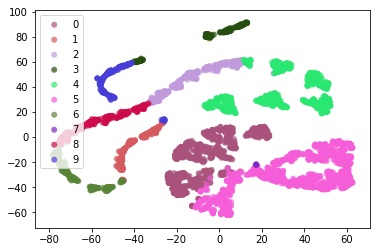

In [65]:
## Visualization of reduced feature vectors in 2D
def plot_scatter(values, cls):
    import matplotlib.pyplot as plt
    # Create a color-map with a different color for each class.
    colors=[np.array([random.random(),random.random(),random.random()]) for label in np.unique(cls)]
    # Extract the x- and y-values.
    for i,color in enumerate(colors):
        selected_values=values[np.argwhere(cls==i).flatten()]
        x=selected_values[:,0]
        y=selected_values[:,1]
        plt.scatter(x, y, c=color, label=i,
               alpha=0.7, edgecolors='none')

    plt.legend()
    plt.show()
plot_scatter(reduced_features, kmeans.labels_)

In [68]:
## Obtain the sum of feature scores to detect customer with the highest score
summed_score=np.sum(feature_vectors, axis=1)

print 'Original feature vectors :'
print feature_vectors[5:]
print 'Summed feature vectors :'
print summed_score[5:].reshape(-1,1)

Original feature vectors :
[[  1.00000000e+00   3.19389249e-01   6.20032379e-01]
 [  9.94638070e-01   1.27588371e-01   5.24061550e-01]
 [  7.66756032e-01   8.36645053e-03   5.13881954e-01]
 ..., 
 [  1.00000000e+00   2.09161263e-04   5.10874071e-01]
 [  1.00000000e+00   1.25496758e-03   5.10411087e-01]
 [  1.00000000e+00   3.97406400e-03   5.10913410e-01]]
Summed feature vectors :
[[ 1.93942163]
 [ 1.64628799]
 [ 1.28900444]
 ..., 
 [ 1.51108323]
 [ 1.51166605]
 [ 1.51488747]]


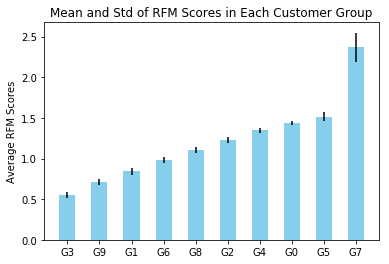

In [70]:
# Obtain class label per customer id
class_labels=kmeans.labels_

## Inspect the characteristic of score of each class and obtain total customer_id in each class groups
total_data_per_class=dict()
class_mean_score_collection=[]
class_std_score_collection=[]
for label in np.unique(class_labels):
    class_score=summed_score[np.argwhere(class_labels==label).flatten()]
    class_mean_score=np.mean(class_score)
    class_std_score=np.std(class_score)
    class_mean_score_collection.append(class_mean_score)
    class_std_score_collection.append(class_std_score)
    total_data_per_class[label]=len(class_score)

## Order the class based on average of summed RFM score
loyal_customer_class_order= np.argsort(class_mean_score_collection)

ordered_class_mean=np.array(class_mean_score_collection)[loyal_customer_class_order]
ordered_class_std=np.array(class_std_score_collection)[loyal_customer_class_order]

## Visualize each groups summed RFM score mean and standard deviation
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

ind = np.arange(len(ordered_class_mean))  # the x locations for the groups
width = 0.5  # the width of the bars

ax.bar(ind, ordered_class_mean, width, yerr=ordered_class_std,color='SkyBlue')

ax.set_ylabel('Average RFM Scores')
ax.set_title('Mean and Std of RFM Scores in Each Customer Group')
ax.set_xticks(ind)
ax.set_xticklabels(('G'+str(i) for i in loyal_customer_class_order))
ax.legend()

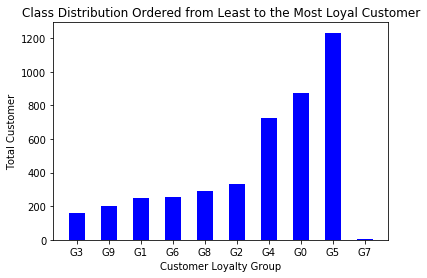

In [71]:
## Sort class based on RFM sum score and visualize data distribution for each class

ind = np.arange(n_class)  # the x locations for the groups
width = 0.5       # the width of the bars
total_customer_per_class=[total_data_per_class[i] for i in loyal_customer_class_order]

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.bar(ind, total_customer_per_class, width, color='b')
ax.set_ylabel('Total Customer')
ax.set_xlabel('Customer Loyalty Group')
ax.set_title('Class Distribution Ordered from Least to the Most Loyal Customer')
ax.set_xticks(ind)
ax.set_xticklabels(('G'+str(i) for i in loyal_customer_class_order))
plt.show()